In [ ]:
import os

os.mkdir("weights")

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as KL
from datetime import timedelta

import datetime
import gc
from tqdm import tqdm
from sklearn import preprocessing
from datetime import datetime
from scipy.signal import savgol_filter

In [2]:
from tensorflow.keras.optimizers import Nadam
import tensorflow as tf
import tensorflow.keras.layers as KL
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

# from tensorflow_addons.losses import pinball_loss
# from tensorflow_addons.optimizers import SWA

In [3]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
import keras.backend as K
import time
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


In [4]:
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [6]:
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import mean_squared_error

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [79]:
train_confirmed = pd.read_csv('../input/covid19-confirmed/Confirmed.csv').rename(columns={"Country/Region": "Country_Region", 'Province/State':'Province_State'})
train_kaggle = pd.read_csv("../input/covid19-global-forecasting-week-5/train.csv")
train_kaggle = train_kaggle[['Province_State','Country_Region','Population','Weight']].drop_duplicates(ignore_index=True)
#test = pd.read_csv("../input/covid19-global-forecasting-week-5/test.csv")
train = pd.merge(train_kaggle, train_confirmed, on=['Province_State', 'Country_Region'], how = 'inner')

In [63]:
temp2 = train[['Province_State','Country_Region','Population','Weight','Lat','Long']].drop_duplicates(ignore_index=True)

In [67]:
train[['Province_State','Country_Region']].drop_duplicates(ignore_index=True)

,Province_State,Country_Region
0,NaN,Afghanistan
1,NaN,Albania
2,NaN,Algeria
3,NaN,Andorra
4,NaN,Angola
...,...,...
258,NaN,West Bank and Gaza
259,NaN,Western Sahara
260,NaN,Yemen
261,NaN,Zambia


In [59]:
temp = temp2.copy().join(pd.DataFrame(columns = pd.date_range(start = fatalities['Date'].max() + pd.Timedelta(days=1), freq = '1D', periods=43)))
test = pd.melt(temp, id_vars=['Province_State','Country_Region','Population','Weight','Lat','Long'], value_vars=temp.iloc[:,6:].columns.tolist(),var_name='Date')

In [76]:
train.columns

Index(['Country_Region', 'Population', 'Weight', 'Lat', 'Long', 'Date',
       'TargetValue', 'weekend'],
      dtype='object')

In [80]:
loc_group = ['Country_Region','Province_State']
def preprocess_data(df):
    df["Date"] = df["Date"].astype("datetime64[ms]")
    df["weekend"] = df["Date"].dt.dayofweek//5
    #df = df.merge(coo_df, how="left", on="Country_Region")
    df["Lat"] = (df["Lat"] // 30).astype(np.float32).fillna(0)
    df["Long"] = (df["Long"] // 60).astype(np.float32).fillna(0)
    df['Population'] = (df["Population"] / df.Population.max()).astype(np.float32).fillna(0)
    df['Province_State'].fillna("",inplace = True)
    #df['County'].fillna("",inplace = True)
    df['Country_Region'] = df['Country_Region'] + ' ' + df['Province_State'] #+ ' ' + df['County']
    del df['Province_State']
    #del df['County']
    return df

df_train = preprocess_data(train)
#df_test = preprocess_data(test)
#print(df_train.head())

TARGETS = ['TargetValue']
NUM_SHIFT = 4

loc_group = ['Country_Region']
##Prepare lag features
df_train = df_train.sort_values(by=loc_group)

###Split train data into devlopment and validation set
TEST_FIRST = df_test["Date"].min() 
TEST_DAYS = (df_test["Date"].max() - TEST_FIRST).days + 1

df_train = df_train.fillna(0)
# df_train['id'] = df_train['Country_Region'].astype('category')
# df_train['id'] = df_train['id'].cat.codes.astype('int16')
features = ["Lat", "Long","Population",'weekend','Weight']
# confirmed = df_train[df_train['Target']=='ConfirmedCases']
# fatalities = df_train[df_train['Target']=='Fatalities']
confirmed =train.sort_values(['Country_Region','Date'])# confirmed.sort_values(by=loc_group)

#fatalities = fatalities.sort_values(by=loc_group)
# confirmed['Target_Value'] = confirmed.groupby('Country_Region')['TargetValue'].apply(lambda x : savgol_filter(x, 5, 2, axis=0))#.reset_index(drop = True)        
# fatalities['Target_Value'] = fatalities.groupby('Country_Region')['TargetValue'].apply(lambda x : savgol_filter(x, 5, 2, axis=0))#.reset_index(drop = True)                                                                                      
confirmed['Target_Value'] = confirmed.groupby('Country_Region')['TargetValue'].transform(lambda x: savgol_filter(x, 11, 2, axis=0))#.reset_index(drop = True)        
#fatalities['Target_Value'] = fatalities.groupby('Country_Region')['TargetValue'].transform(lambda x: savgol_filter(x, 11, 2, axis=0))
prev_features = []
for s in range(1, NUM_SHIFT+1):
    for col in TARGETS:
        confirmed["prev_{}_{}".format(col, s)] = confirmed.groupby(loc_group)[col].shift(s)
        #fatalities["prev_{}_{}".format(col, s)] = fatalities.groupby(loc_group)[col].shift(s)
        features.append("prev_{}_{}".format(col, s))
        prev_features.append("prev_{}_{}".format(col, s))
TARGETS = ['Target_Value']

In [81]:
confirmed = confirmed[confirmed['TargetValue']>0]
confirmed = confirmed[confirmed['Country_Region'].groupby(confirmed['Country_Region']).transform('size') > 50]
confirmed = confirmed.sort_values(['Country_Region', 'Date']).reset_index(drop = True)

In [82]:
confirmed.head()

,Country_Region,Population,Weight,Lat,Long,Date,TargetValue,weekend,Target_Value,prev_TargetValue_1,prev_TargetValue_2,prev_TargetValue_3,prev_TargetValue_4
0,Afghanistan,0.021353,0.058359,1.0,1.0,2020-02-24,1,0,0.603730,0.0,0.0,0.0,0.0
1,Afghanistan,0.021353,0.583587,1.0,1.0,2020-02-24,1,0,0.799534,1.0,0.0,0.0,0.0
2,Afghanistan,0.021353,0.058359,1.0,1.0,2020-02-25,1,0,0.960373,1.0,1.0,0.0,0.0
3,Afghanistan,0.021353,0.583587,1.0,1.0,2020-02-25,1,0,1.062937,1.0,1.0,1.0,0.0
4,Afghanistan,0.021353,0.058359,1.0,1.0,2020-02-26,1,0,1.083916,1.0,1.0,1.0,1.0


In [83]:
Region = confirmed.Country_Region.unique().tolist()

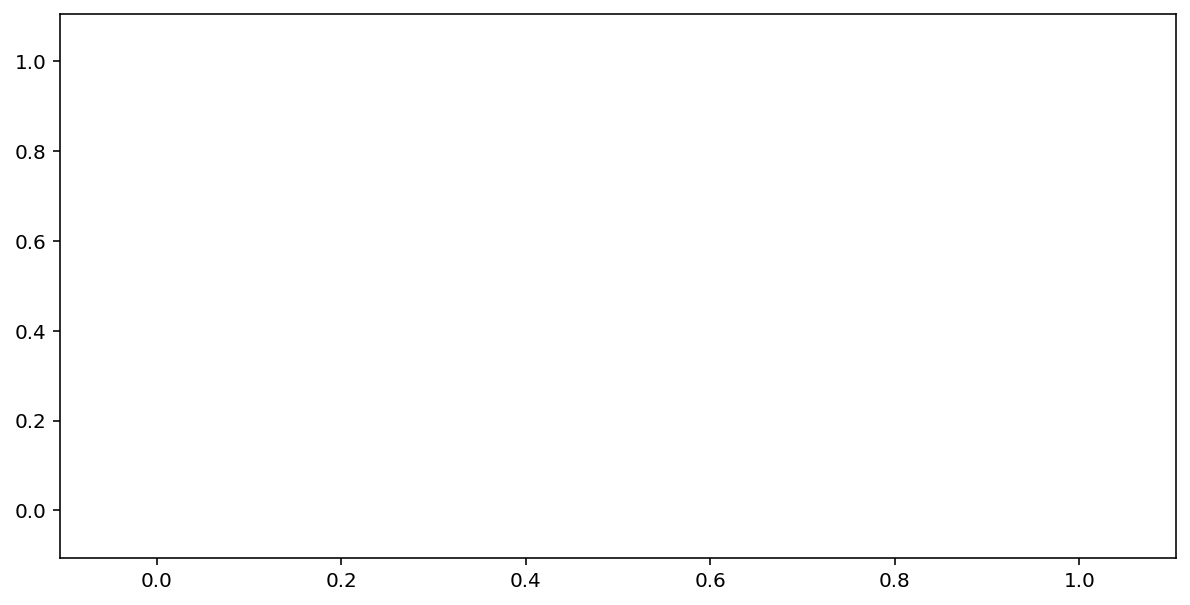

In [84]:
fig = plt.figure(figsize=(10,5))
plt.plot(range(0, len(confirmed[confirmed['Country_Region']=='Albania  '])),confirmed[confirmed['Country_Region']=='Albania  ']['Target_Value'], label='filtered')
plt.plot(range(0, len(confirmed[confirmed['Country_Region']=='Albania  '])),confirmed[confirmed['Country_Region']=='Albania  ']['TargetValue'], label='actual')
plt.show()

In [85]:
features

['Lat',
 'Long',
 'Population',
 'weekend',
 'Weight',
 'prev_TargetValue_1',
 'prev_TargetValue_2',
 'prev_TargetValue_3',
 'prev_TargetValue_4']

In [86]:
def scale_data(features, y): 
    min_max_scaler_x = MinMaxScaler()
    X = min_max_scaler_x.fit_transform(features)
    
    min_max_scaler_y = MinMaxScaler()
    Y = min_max_scaler_y.fit_transform(y)
    return min_max_scaler_x,min_max_scaler_y,X,Y

In [87]:
Unique_Regions = df_train['Country_Region'].unique().tolist()
confirmed_scale_x, confirmed_scale_y, confirmed[features], confirmed['TargetValue'] = scale_data(confirmed[features], confirmed['TargetValue'].values.reshape(-1, 1))

dev_cc, test_cc = confirmed[confirmed["Date"] < TEST_FIRST].copy(), confirmed[confirmed["Date"] >= TEST_FIRST].copy().reset_index(drop=True)
dev_ft, test_ft = fatalities[fatalities['Date'] < TEST_FIRST].copy(), fatalities[fatalities['Date'] >= TEST_FIRST].copy().reset_index(drop=True)
dev_cc.fillna(1e-10, inplace=True)#1e-10
dev_ft.fillna(1e-10, inplace=True)
test_cc.fillna(1e-10, inplace=True)
test_ft.fillna(1e-10, inplace=True)

#X_train_cc, X_val_cc, y_train_cc, y_val_cc, scaler_cc, y_scaler = scale_data(dev_cc[features].to_numpy(), test_cc[features].to_numpy(), dev_cc[['Target_Value']].to_numpy(), test_cc[['Target_Value']].to_numpy())
X_train_cc = dev_cc[features].to_numpy()
X_val_cc = test_cc[features].to_numpy()

y_train_cc = dev_cc[['TargetValue']].to_numpy()
y_val_cc = test_cc[['TargetValue']].to_numpy()

X_train_ft = dev_ft[features].to_numpy()
X_val_ft = test_ft[features].to_numpy()

y_train_ft = dev_ft[['TargetValue']].to_numpy()
y_val_ft = test_ft[['TargetValue']].to_numpy()#X_train_cc, X_val_cc, y_train_cc, y_val_cc, scaler_cc, y_scaler_cc = scale_data(X_train_cc, X_val_cc, y_train_cc, y_val_cc)#

In [88]:
x_train = confirmed[features].to_numpy()
y_train = confirmed[['TargetValue']].to_numpy()
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])
x_train.shape

(96594, 1, 9)

In [89]:
X_train_cc = X_train_cc.reshape(X_train_cc.shape[0], 1, X_train_cc.shape[1])
X_val_cc = X_val_cc.reshape(X_val_cc.shape[0], 1, X_val_cc.shape[1])

X_train_ft = X_train_ft.reshape(X_train_ft.shape[0], 1, X_train_ft.shape[1])
X_val_ft = X_val_ft.reshape(X_val_ft.shape[0], 1, X_val_ft.shape[1])

print(X_train_cc.shape,y_train_cc.shape, X_val_cc.shape)#, X_train_ft.shape, X_val_ft.shape)

(30330, 1, 9) (30330, 1) (66264, 1, 9)


In [17]:
def tilted_loss(y,f,q):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [90]:
def pinball_loss(true, pred, quantile):
    #quantile = 0.05
    assert pred.shape[0]==true.shape[0]
    loss1 = (true - pred) *  quantile
    loss2 = (pred - true) * (1 - quantile)
    loss1 = K.clip(loss1, 0, K.max(loss1))
    loss2 = K.clip(loss2, 0, K.max(loss2))
    loss = loss1 + loss2
    print(loss.shape, pred.shape)
    loss = K.mean(true * loss)
    return loss

In [91]:
##Reference : https://github.com/tensorflow/addons/blob/master/tensorflow_addons/losses/quantiles.py
def pinball_loss(
    y_true, y_pred, tau
):
    """Computes the pinball loss between `y_true` and `y_pred`.
    `loss = maximum(tau * (y_true - y_pred), (tau - 1) * (y_true - y_pred))`
    In the context of regression this, loss yields an estimator of the tau
    conditional quantile.
    See: https://en.wikipedia.org/wiki/Quantile_regression
    Usage:
    ```python
    loss = pinball_loss([0., 0., 1., 1.], [1., 1., 1., 0.], tau=.1)
    # loss = max(0.1 * (y_true - y_pred), (0.1 - 1) * (y_true - y_pred))
    #      = (0.9 + 0.9 + 0 + 0.1) / 4
    print('Loss: ', loss.numpy())  # Loss: 0.475
    ```
    Args:
      y_true: Ground truth values. shape = `[batch_size, d0, .. dN]`
      y_pred: The predicted values. shape = `[batch_size, d0, .. dN]`
      tau: (Optional) Float in [0, 1] or a tensor taking values in [0, 1] and
        shape = `[d0,..., dn]`.  It defines the slope of the pinball loss. In
        the context of quantile regression, the value of tau determines the
        conditional quantile level. When tau = 0.5, this amounts to l1
        regression, an estimator of the conditional median (0.5 quantile).
    Returns:
        pinball_loss: 1-D float `Tensor` with shape [batch_size].
    References:
      - https://en.wikipedia.org/wiki/Quantile_regression
      - https://projecteuclid.org/download/pdfview_1/euclid.bj/1297173840
    """
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    # Broadcast the pinball slope along the batch dimension
    tau = tf.expand_dims(tf.cast(tau, y_pred.dtype), 0)
    one = tf.cast(1, tau.dtype)

    delta_y = y_true - y_pred
    pinball = tf.math.maximum(tau * delta_y, (tau - one) * delta_y)
    return tf.reduce_mean(pinball, axis=-1)

In [92]:
def get_custom_loss(q):
    def custom_loss(y_true, y_pred):
        return pinball_loss(y_true, y_pred, q)
    return custom_loss

In [93]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 32]))
HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.1, 0.2))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))

METRIC_ACCURACY = 'mean_squared_error'

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
    hparams=[HP_NUM_UNITS, HP_DROPOUT, HP_OPTIMIZER],
    metrics=[hp.Metric(METRIC_ACCURACY, display_name='mean_squared_error')],
  )

In [94]:
def bidirectionalLSTM(input_dim, output_dim, x_train, y_train, x_test, y_test,hparams): 
    model = tf.keras.models.Sequential([
    layers.Bidirectional(layers.LSTM(100, return_sequences=True), input_shape=(1, input_dim)),        
    tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation=tf.nn.relu),
    tf.keras.layers.Dropout(hparams[HP_DROPOUT]),
    tf.keras.layers.Dense(output_dim),
  ])
    #model.summary()
    model.compile(
      optimizer=hparams[HP_OPTIMIZER],
      loss=lambda y,f: pinball_loss(y,f, 0.5),
      metrics=['mean_squared_error'],
  )
    early_stop_cc = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
    model.fit(x_train, y_train, epochs=50, callbacks=[early_stop_cc]) # Run with 1 epoch to speed things up for demo purposes
    _, mse = model.evaluate(x_test, y_test)
    return model, mse

In [43]:
def run(run_dir, hparams):
    with tf.summary.create_file_writer(run_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        mse = bidirectionalLSTM(X_train_cc.shape[-1], y_train_cc.shape[-1], X_train_cc,y_train_cc, X_val_cc, y_val_cc,hparams)
        tf.summary.scalar(METRIC_ACCURACY, mse, step=1)

In [24]:
session_num = 0
for num_units in HP_NUM_UNITS.domain.values:
    for dropout_rate in (HP_DROPOUT.domain.min_value, HP_DROPOUT.domain.max_value):
        for optimizer in HP_OPTIMIZER.domain.values:
            hparams = {
              HP_NUM_UNITS: num_units,
              HP_DROPOUT: dropout_rate,
              HP_OPTIMIZER: optimizer,
            }
            run_name = "run-%d" % session_num
            print('--- Starting trial: %s' % run_name)
            print({h.name: hparams[h] for h in hparams})
            run('logs/hparam_tuning/' + run_name, hparams)
            session_num += 1

--- Starting trial: run-0
{'num_units': 16, 'dropout': 0.1, 'optimizer': 'adam'}
Train on 37965 samples
Epoch 1/50
18944/37965 [=============>................] - ETA: 4s - loss: 0.0018 - mean_squared_error: 7.7310e-04

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


KeyboardInterrupt: 

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/ 
%tensorboard --logdir logs/hparam_tuning

In [25]:
print('Start model training')
start_time = time.time()
history_cc = model_cc.fit(X_train_cc, y_train_cc, batch_size = 2048, epochs = 100,validation_data = (X_val_cc, y_val_cc), verbose = 2, callbacks=[early_stop_cc])

Start model training


NameError: name 'model_cc' is not defined

In [ ]:
##Bidirectional
plt.figure(figsize=(8,5))
plt.plot(history_cc.history['loss'])
plt.plot(history_cc.history['val_loss'])
plt.title('CC Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
def LSTM_model(n_1, input_dim, output_dim):
    model = Sequential()
    model.add(LSTM(n_1,input_shape=(1, input_dim),return_sequences = True,kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros"))#, ,return_sequences=True
    model.add(Dropout(0.3))
    model.add(LSTM(units = n_1))
    model.add(Dropout(0.3))
    #model.add(LSTM(n_2, activation='relu'))
    model.add(Dense(output_dim))#
    model.add(Lambda(
        lambda x: tf.math.cumsum(x, axis=1),
))
    #adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
    adam = Adam(lr=0.01, name='adam',beta_1=0.9, beta_2=0.999, amsgrad=False)
    #model.compile(loss=lambda y,f: tilted_loss(y,f, quantile), optimizer='Nadam')#, lambda y,f: pinball_loss1(y,f, quantile)
    #model.summary()
    return model

K.clear_session()   
#model_cc = LSTM_model(20, X_train_cc.shape[-1], y_train_cc.shape[-1])
early_stop_cc = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

In [ ]:
NUM_MODELS = 35
NUM_ITER = 5
targets = ['TargetValue']

In [ ]:
for days_ahead in range(1, NUM_MODELS+1):
    print("Training {}...".format(days_ahead))
    df = confirmed.copy()
    for target in targets:
        df["confirmed_{}".format(target)] = df.groupby("Country_Region")[targets[0]].shift(1-days_ahead)
    #print(df.columns)    
    train_dff = df[df["confirmed_{}".format(targets[0])].notnull()].copy()
    train_dff.fillna(0, inplace = True)
    print(train_dff[prev_features].shape)
    train_df = train_dff[prev_features].to_numpy()
    X_hist_train = train_df.reshape(train_df.shape[0], 1, NUM_SHIFT)
    y_train_cc = train_dff[["confirmed_{}".format(targets[0])]].to_numpy()
    epochs = [10, 4]
    if days_ahead >= 20:
        epochs = [6, 2]
    for it in range(NUM_ITER):
        print("Iteration:", it)
        #K.clear_session()
        model = LSTM_model(20, X_hist_train.shape[-1], y_train_cc.shape[-1])
        for loss, lr, epoch in [(get_custom_loss([0.15, 0.50, 0.85]), 0.0001, epochs[0]), (get_custom_loss([0.05, 0.50, 0.95]), 0.00005, epochs[1])]:
            model.compile(loss=loss, optimizer='Nadam')
            model.fit(X_hist_train, y_train_cc, #sample_weight=get_weight(train_df),
                      shuffle=True, batch_size=128, epochs=epoch, verbose=0)
    
        model.save_weights("weights/model_{d}_{it}.h5".format(d=days_ahead, it=it))

In [ ]:
print('Start model training')
start_time = time.time()
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")
history_cc = model_cc.fit(X_train_cc, y_train_cc, batch_size = 2048, epochs = 50,validation_data = (X_val_cc, y_val_cc), verbose = 2, callbacks=[early_stop_cc])
model_cc.save("model_cc.h5")
print('Time spent for model training is {} minutes'.format(round((time.time()-start_time)/60,1)))

In [ ]:
print('Start model training')
start_time = time.time()
tensorboard_callback = tf.keras.callbacks.TensorBoard("logs")
history_cc = model_cc.fit(X_train_cc, y_train_cc, batch_size = 2048, epochs = 50,validation_data = (X_val_cc, y_val_cc), verbose = 2, callbacks=[early_stop_cc])
model_cc.save("model_cc.h5")
print('Time spent for model training is {} minutes'.format(round((time.time()-start_time)/60,1)))

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_cc.history['loss'])
plt.plot(history_cc.history['val_loss'])
plt.title('CC Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
K.clear_session()   
model_ft = LSTM_model(20, X_train_ft.shape[-1], y_train_ft.shape[-1], 0.5)
early_stop_cc = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

In [95]:
params = {HP_NUM_UNITS: 32, HP_DROPOUT: 0.2, HP_OPTIMIZER: 'adam'}
model, mse =  bidirectionalLSTM(X_train_cc.shape[-1], y_train_cc.shape[-1], X_train_cc, y_train_cc, X_val_cc, y_val_cc, params)

Train on 30330 samples
Epoch 1/50
30330/30330 [==============================] - 6s 205us/sample - loss: 3.8259e-04 - mean_squared_error: 1.6038e-05
Epoch 2/50
 1408/30330 [>.............................] - ETA: 3s - loss: 2.0774e-04 - mean_squared_error: 2.6120e-06

/opt/conda/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_squared_error
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


30330/30330 [==============================] - 4s 117us/sample - loss: 1.9630e-04 - mean_squared_error: 6.3230e-06
Epoch 3/50
30330/30330 [==============================] - 3s 113us/sample - loss: 1.7937e-04 - mean_squared_error: 6.4162e-06
Epoch 4/50
30330/30330 [==============================] - 3s 109us/sample - loss: 1.6583e-04 - mean_squared_error: 4.4536e-06
Epoch 5/50
30330/30330 [==============================] - 3s 112us/sample - loss: 1.6718e-04 - mean_squared_error: 5.5462e-06
Epoch 6/50
30330/30330 [==============================] - 3s 107us/sample - loss: 1.7326e-04 - mean_squared_error: 5.4967e-06
Epoch 7/50
30330/30330 [==============================] - 3s 105us/sample - loss: 1.5195e-04 - mean_squared_error: 4.3609e-06
Epoch 8/50
30330/30330 [==============================] - 3s 109us/sample - loss: 1.5610e-04 - mean_squared_error: 6.0912e-06
Epoch 9/50
30330/30330 [==============================] - 3s 105us/sample - loss: 1.5389e-04 - mean_squared_error: 6.1682e-06
Epo

In [71]:
from eli5.permutation_importance import get_score_importances
# ... load data, define score function
def score(X, y):
    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred,squared=False)
base_score, score_decreases = get_score_importances(score, X_val_cc, y_val_cc)
feature_importances = np.mean(score_decreases, axis=0)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [28]:
perm = PermutationImportance(model, random_state=1).fit(X_train_cc,y_train_cc)
eli5.show_weights(perm, feature_names = features)

TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f95c2a622d0> does not.

In [38]:
explainer = shap.DeepExplainer(model, X_train_cc)
shap_values = explainer.shap_values(X_val_cc)

AssertionError: The model output must be a vector or a single value!

In [32]:
TARGETS = ['TargetValue']
#confirmed_US = confirmed[confirmed.Country_Region.str.contains('US')]
confirmed.fillna(0, inplace = True)
df_test_confirmed = df_test[(df_test['Target']=='ConfirmedCases') & (df_test['Country_Region'].isin(Region))]
#country = df_test_confirmed['Country_Region'].unique().tolist()
# fill data for overlapped days
test_dff = df_test_confirmed.copy().join(pd.DataFrame(columns = ['prev_TargetValue_1','prev_TargetValue_2','prev_TargetValue_3','prev_TargetValue_4']+TARGETS))
lags = np.arange(1,4,1)
# test_overlap_mask = (test_dff['Date'] <= confirmed_US['Date'].max())
# train_overlap_mask = (confirmed_US['Date'] >= test_dff['Date'].min())

In [36]:
test_dff.Date.max()

Timestamp('2020-06-10 00:00:00')

In [35]:
confirmed['Date'].max()

Timestamp('2020-06-10 00:00:00')

In [29]:
test_dff = test_dff[test_dff['Date']>confirmed['Date'].max()]

In [30]:
test_dff.head()

,ForecastId,Country_Region,Population,Weight,Date,Target,weekend,Lat,Long,prev_TargetValue_1,prev_TargetValue_2,prev_TargetValue_3,prev_TargetValue_4,TargetValue


In [ ]:
confirmed

In [67]:
# test_dff['id'] = test_dff['Country_Region'].astype('category')
# test_dff['id'] = test_dff['id'].cat.codes.astype('int16')
test_dff.loc[test_overlap_mask, features + TARGETS] = confirmed_US.loc[train_overlap_mask, features + TARGETS].values

ValueError: shape mismatch: value array of shape (25033,) could not be broadcast to indexing result of shape (28575,)

In [ ]:
pred_dt_range = pd.date_range(start = confirmed['Date'].max() + pd.Timedelta(days=1), end = test_dff['Date'].max(), freq = '1D')

,Id,Country_Region,Population,Weight,Date,Target,TargetValue,weekend,Lat,Long,id,Target_Value,prev_TargetValue_1,prev_TargetValue_2,prev_TargetValue_3,prev_TargetValue_4
11079,963015,US,0.232225,0.057616,2020-03-10,ConfirmedCases,0.024612,0.0,0.75,0.0,242,426.536131,0.217200,0.217200,0.217200,0.217200
11080,963017,US,0.232225,0.057616,2020-03-11,ConfirmedCases,0.008849,0.0,0.75,0.0,242,1265.062937,0.236509,0.217200,0.217200,0.217200
11081,963019,US,0.232225,0.057616,2020-03-12,ConfirmedCases,0.010509,0.0,0.75,0.0,242,1782.592075,0.224170,0.236509,0.217200,0.217200
11082,963021,US,0.232225,0.057616,2020-03-13,ConfirmedCases,0.014214,0.0,0.75,0.0,242,2043.990676,0.225469,0.224170,0.236509,0.217200
11083,963023,US,0.232225,0.057616,2020-03-14,ConfirmedCases,0.015044,1.0,0.75,0.0,242,1798.396270,0.397515,0.228370,0.225469,0.224170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56476,962911,US Wyoming,0.000407,0.454077,2020-06-06,ConfirmedCases,0.000111,1.0,0.75,0.0,3416,11.501166,0.217460,0.217395,0.217417,0.217287
56477,962913,US Wyoming,0.000407,0.454077,2020-06-07,ConfirmedCases,0.000166,1.0,0.75,0.0,3416,8.494172,0.217482,0.217417,0.217244,0.217352
56478,962915,US Wyoming,0.000407,0.454077,2020-06-08,ConfirmedCases,0.000304,0.0,0.75,0.0,3416,8.687646,0.217417,0.217244,0.217352,0.217308
56479,962917,US Wyoming,0.000407,0.454077,2020-06-09,ConfirmedCases,0.000221,0.0,0.75,0.0,3416,6.440559,0.217265,0.217330,0.217460,0.217308


In [ ]:
for s in range(1, NUM_SHIFT+1):
    for col in TARGETS:
        test_dff["prev_{}_{}".format(col, s)] = test_dff.groupby(loc_group)[col].shift(s)

In [ ]:
test_dff[test_dff['Country_Region']=='Afghanistan  '].head(100)

In [ ]:
test_dff[test_dff['Country_Region'].str.contains("US")].Country_Region.unique().tolist()

In [ ]:
country = test_dff[test_dff['Country_Region'].str.contains("US")].Country_Region.unique().tolist()#['US Arkansas Marion', 'US Arkansas Miller', 'US Arkansas Mississippi']#
test_dff = test_dff.sort_values(['Country_Region','Date'])
with tqdm(total = len(pred_dt_range)) as pbar:
    for i in country: 
        for d in pred_dt_range:
            mask = (test_dff['Date'] == d) & (test_dff['Country_Region'] == i) 
            #print(mask)
            for lag in lags:
                mask_org = (test_dff['Date'] == (d - pd.Timedelta(days=lag)))
                print(d - pd.Timedelta(days=lag))
                try:
                    test_dff.loc[mask, 'prev_TargetValue_' + str(lag)] = test_dff.loc[mask_org, 'TargetValue'].values
                    #print(test_dff.loc[mask_org, 'TargetValue'].values)
                except:
                    test_dff.loc[mask, 'prev_TargetValue_' + str(lag)] = 0


            #print(mask)
            #print(test_dff.loc[mask, features].head())     
            test_X  = test_dff.loc[mask, features]
            # predict for comfirmed cases
            X_test_cc = test_X[features].to_numpy()
            #X_test_cc= test_X_cc
            #X_test_cc =  scaler_cc.transform(X_test_cc) # intput/output 2D array-like
            X_test_cc = X_test_cc.reshape(X_test_cc.shape[0], 1, X_test_cc.shape[1])
            next_cc = model_cc.predict(X_test_cc).clip(0)

        # update yhat for next day
            test_dff.loc[mask, 'TargetValue'] = next_cc

        #pbar.update(1)

In [ ]:
for country in ['US Arkansas Marion','US Arkansas Miller','US Arkansas Mississippi']:
#country = 'India  '#country = 'China Beijing '
    print(country)
    fig = plt.figure(figsize=(10,5))
    train_cc = confirmed[(confirmed['Country_Region']==country)]
    test_cc = test_dff[(test_dff['Country_Region']==country) ]
    train_cc.sort_values(['Country_Region','Date'], inplace = True)
    test_cc.sort_values(['Country_Region','Date'], inplace = True)
    y1 = train_cc['TargetValue']
    x1 = train_cc['Date']
    y = test_cc['TargetValue']
    x = test_cc['Date']
    plt.plot(x, y)
    plt.plot(x1, y1)
    plt.show()

In [ ]:
for country in test_dff.Country_Region.unique().tolist():
#country = 'China Beijing '
    print(country)
    fig = plt.figure(figsize=(10,5))
    train_cc = confirmed[(confirmed['Country_Region']==country)]
    test_cc = test_dff[(test_dff['Country_Region']==country) ]
    train_cc.sort_values(['Country_Region','Date'], inplace = True)
    test_cc.sort_values(['Country_Region','Date'], inplace = True)
    y1 = train_cc['TargetValue']
    x1 = train_cc['Date']
    y = test_cc['TargetValue']
    x = test_cc['Date']
    plt.plot(x, y)
    plt.plot(x1, y1)
    plt.show()

In [ ]:
for country in test_dff[test_dff['Country_Region'].str.contains("US")].Country_Region.unique().tolist():
#country = 'China Beijing '
    print(country)
    fig = plt.figure(figsize=(10,5))
    train_cc = confirmed[(confirmed['Country_Region']==country)]
    test_cc = test_dff[(test_dff['Country_Region']==country) ]
    train_cc.sort_values(['Country_Region','Date'], inplace = True)
    test_cc.sort_values(['Country_Region','Date'], inplace = True)
    y1 = train_cc['TargetValue']
    x1 = train_cc['Date']
    y = test_cc['TargetValue']
    x = test_cc['Date']
    plt.plot(x, y)
    plt.plot(x1, y1)
    plt.show()

Predicting fatalities

In [ ]:
df_test.head()

In [ ]:
TARGETS = ['TargetValue']
confirmed.fillna(0, inplace = True)
df_test_fatalities = df_test[df_test['Target']=='Fatalities']
country = df_test_fatalities['Country_Region'].unique().tolist()
# fill data for overlapped days
test_dff = df_test_fatalities.copy().join(pd.DataFrame(columns = ['prev_TargetValue_1','prev_TargetValue_2','prev_TargetValue_3','prev_TargetValue_4','prev_TargetValue_5','prev_TargetValue_6','prev_TargetValue_7','prev_TargetValue_8','prev_TargetValue_9','prev_TargetValue_10','prev_TargetValue_11','prev_TargetValue_12','prev_TargetValue_13','prev_TargetValue_14']+TARGETS))
lags = np.arange(1,15,1)
test_overlap_mask = (test_dff['Date'] <= fatalities['Date'].max())
train_overlap_mask = (fatalities['Date'] >= test_dff['Date'].min())

In [ ]:
test_dff['id'] = test_dff['Country_Region'].astype('category')
test_dff['id'] = test_dff['id'].cat.codes.astype('int16')
test_dff.loc[test_overlap_mask, features + TARGETS] = fatalities.loc[train_overlap_mask, features + TARGETS].values

In [ ]:
pred_dt_range = pd.date_range(start = fatalities['Date'].max() + pd.Timedelta(days=1), end = test_dff['Date'].max(), freq = '1D')

In [ ]:
df_test_fatalities['Country_Region'].unique().tolist()

In [ ]:
n_country = ['Afghanistan  ',
 'Albania  ',
 'Algeria  ',
 'Andorra  ',
 'Angola  ',
 'Antigua and Barbuda  ',
 'Argentina  ',
 'Armenia  ',
 'Australia  ',
 'Australia Australian Capital Territory ',
 'Australia New South Wales ',
 'Australia Northern Territory ',
 'Australia Queensland ',
 'Australia South Australia ',
 'Australia Tasmania ',
 'Australia Victoria ',
 'Australia Western Australia ',
 'China Anhui ',
 'China Beijing ',
 'China Chongqing ',
 'China Fujian ',
 'China Gansu ',
 'China Guangdong ',
 'China Guangxi ',
 'China Guizhou ',
 'China Hainan ',
 'China Hebei ',
 'China Heilongjiang '
 ,'India  ',
 'Indonesia  ',
 'Iran  ',
 'Iraq  ']

In [ ]:
#country = [ 'US Arkansas Marion','US Arkansas Miller','US Arkansas Mississippi', 'India  ', 'China']#test_dff[test_dff['Country_Region'].str.contains("US")].Country_Region.unique().tolist()
test_dff = test_dff.sort_values(['Country_Region','Date'])
test_dff = test_dff[test_dff.Country_Region.isin(n_country)]
with tqdm(total = len(pred_dt_range)) as pbar:
    for i in n_country: 
        for d in pred_dt_range:
            mask = (test_dff['Date'] == d) & (test_dff['Country_Region'] == i) 
            #print(mask)
            for lag in lags:
                mask_org = (test_dff['Date'] == (d - pd.Timedelta(days=lag)))
                print(d - pd.Timedelta(days=lag))
                try:
                    test_dff.loc[mask, 'prev_TargetValue_' + str(lag)] = test_dff.loc[mask_org, 'TargetValue'].values
                    #print(test_dff.loc[mask_org, 'TargetValue'].values)
                except:
                    test_dff.loc[mask, 'prev_TargetValue_' + str(lag)] = 0


            #print(mask)
            #print(test_dff.loc[mask, features].head())     
            test_X  = test_dff.loc[mask, features]
            # predict for comfirmed cases
            X_test_cc = test_X[features].to_numpy()
            #X_test_cc= test_X_cc
            #X_test_cc =  scaler_cc.transform(X_test_cc) # intput/output 2D array-like
            X_test_cc = X_test_cc.reshape(X_test_cc.shape[0], 1, X_test_cc.shape[1])
            next_cc = model_ft.predict(X_test_cc).clip(0)

        # update yhat for next day
            test_dff.loc[mask, 'TargetValue'] = next_cc

        #pbar.update(1)

Plotting fatalities

In [ ]:
for country in n_country:
#country = 'China Beijing '
    print(country)
    fig = plt.figure(figsize=(10,5))
    train_ft = fatalities[(fatalities['Country_Region']==country)]
    test_ft = test_dff[(test_dff['Country_Region']==country) ]
    train_ft.sort_values(['Country_Region','Date'], inplace = True)
    test_ft.sort_values(['Country_Region','Date'], inplace = True)
    y1 = train_ft['TargetValue']
    x1 = train_ft['Date']
    y = test_ft['TargetValue']
    x = test_ft['Date']
    plt.plot(x, y)
    plt.plot(x1, y1)
    plt.show()

In [ ]:
for country in n_country:
#country = 'China Beijing '
    print(country)
    fig = plt.figure(figsize=(10,5))
    train_ft = fatalities[(fatalities['Country_Region']==country)]
    test_ft = test_dff[(test_dff['Country_Region']==country) ]
    train_ft.sort_values(['Country_Region','Date'], inplace = True)
    test_ft.sort_values(['Country_Region','Date'], inplace = True)
    y1 = train_ft['TargetValue']
    x1 = train_ft['Date']
    y = test_ft['TargetValue']
    x = test_ft['Date']
    plt.plot(x, y)
    plt.plot(x1, y1)
    plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs